In [1]:
import cv2
import numpy as np
# import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
import os
import PIL
from PIL import Image
# %matplotlib notebook
# PIL.Image.MAX_IMAGE_PIXELS = 933120000

In [ ]:
!gdown --id 1umso1scO-DY0pR7SocBMMif08Zfxx9os
!gdown --id 1-5BEz_Ul343gEZtCbSeNoDeJSV0h7w0Z
!unzip train_input.zip
!unzip train_output.zip


def rgba_to_rgb(path):
    for dir in os.listdir(path):
        filename = os.path.join(path,dir)
        # print(Image.open(os.path.join("./inputs/train_input",dir)).convert("RGB").mode )
        if Image.open(filename).mode == "RGBA":
            png = Image.open(filename)
            png.load() # required for png.split()
            background = Image.new("RGB", png.size, (255, 255, 255))
            background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
            background.save(filename, 'png', quality=80)

rgba_to_rgb("./content/train_input")
rgba_to_rgb("./content/train_output")


def check_rgba(path):
    count=0
    for dir in os.listdir(path):
        filename = os.path.join(path,dir)
        if Image.open(filename).mode == "RGBA":
            count+=1
    print(count)

print(check_rgba("./content/train_input"))
print(check_rgba("./content/train_output"))


len(os.listdir("./content/train_input")), len(os.listdir("./content/train_output"))

0
None
0
None


(2730, 2725)

In [ ]:
!pip install matplotlib==3.1

# From here

In [1]:
!pip install image_registration

     |████████████████████████████████| 2.8 MB 7.3 MB/s 
     |████████████████████████████████| 167 kB 50.6 MB/s 
  Created wheel for image-registration: filename=image_registration-0.2.4-py3-none-any.whl size=68384 sha256=6047dc21aec2a31d3b463bfcddb7aa47808651c6b17360a0a09b3143450c0ba2
  Stored in directory: /root/.cache/pip/wheels/53/6e/a7/88756ce112b92bc1fe97a115abd33c8c7e756cc734d989ff29
  Created wheel for FITS-tools: filename=FITS_tools-0.2-py3-none-any.whl size=30986 sha256=604505b7a2a2c1837ad3723fe139b56db00917fb96be72ca68d002efe91760a6
  Stored in directory: /root/.cache/pip/wheels/42/12/16/11103ef889df58e140f435d613138791d9d9e9a99d6f06432c
Successfully built image-registration FITS-tools


In [ ]:
def resize_image(image):
    return cv2.resize(image, (256, 256), interpolation = cv2.INTER_CUBIC)

def rotate_image(image):
    return cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)

def color_it_black(image):
    np_image = np.array(image)
    print(np_image.shape, np_image.min(), np_image.max())
    for i in range(np_image.shape[0]):
        for j in range(np_image.shape[1]):
            np_image[i,j] = 0 if np_image[i,j] < 200 else 255
    print(np_image.shape, np_image.min(), np_image.max())
    return np_image
    # return Image.fromarray( np_image, "L" )

image1 = "/content/photos/1.png"
image = cv2.imread(image1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
color_it_black(image)

(256, 256) 0 255
(256, 256) 0 255
(256, 256) 0 255
(256, 256) 0 255
(256, 256) (256, 256)
Pixels shifted by:  -22.638671875 -31.740234375


/usr/local/lib/python3.7/dist-packages/image_registration/fft_tools/convolve_nd.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/usr/local/lib/python3.7/dist-packages/image_registration/fft_tools/convolve_nd.py:270: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = kernel
/usr/local/lib/python3.7/dist-packages/image_registration/fft_tools/convolve_nd.py:325: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[se

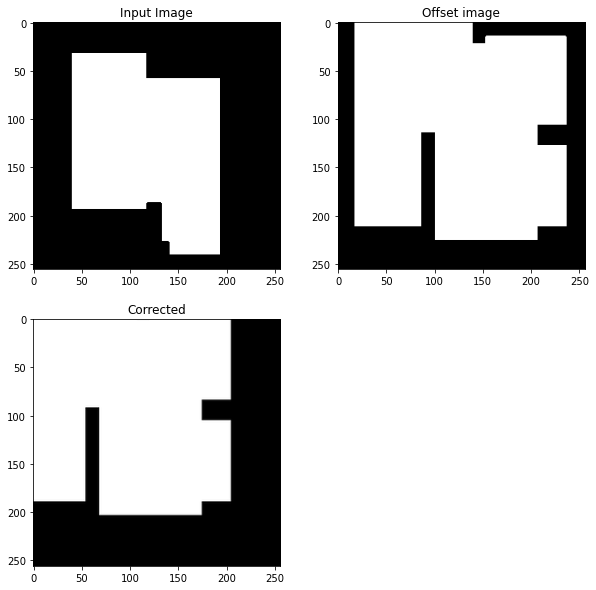

In [12]:
#Method 1: chi squared shift
from skimage import io
from image_registration import chi2_shift
import cv2
image1 = "/content/photos/1.png"
image2 = "/content/photos/3.png"

image = io.imread(image1)
offset_image = io.imread(image2)

image = cv2.imread(image1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
w, h = image.shape

offset_image = cv2.imread(image2)
offset_image = cv2.cvtColor(offset_image, cv2.COLOR_BGR2GRAY)
offset_image = cv2.resize(offset_image, (h,w)) 

# Resize both images to same shape
offset_image = resize_image(offset_image)
image = resize_image(image)
# Rotate offset_image
offset_image = rotate_image(offset_image)

# conver to complete black
offset_image = color_it_black(offset_image)
image = color_it_black(image)
print(image.shape, offset_image.shape)

#Method 1: chi squared shift
#Find the offsets between image 1 and image 2 using the DFT upsampling method
noise=0.1
xoff, yoff, exoff, eyoff = chi2_shift(image, offset_image, noise, 
                                      return_error=True, upsample_factor='auto')

print("Pixels shifted by: ", xoff, yoff)

from scipy.ndimage import shift
corrected_image = shift(offset_image, shift=(xoff,yoff), mode='constant')

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(offset_image, cmap='gray')
ax2.title.set_text('Offset image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(corrected_image, cmap='gray')
ax3.title.set_text('Corrected')
plt.show()

/usr/local/lib/python3.7/dist-packages/image_registration/fft_tools/convolve_nd.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/usr/local/lib/python3.7/dist-packages/image_registration/fft_tools/convolve_nd.py:270: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = kernel
/usr/local/lib/python3.7/dist-packages/image_registration/fft_tools/convolve_nd.py:325: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[se

Pixels shifted by:  -22.04594380668612 -31.84930754067285


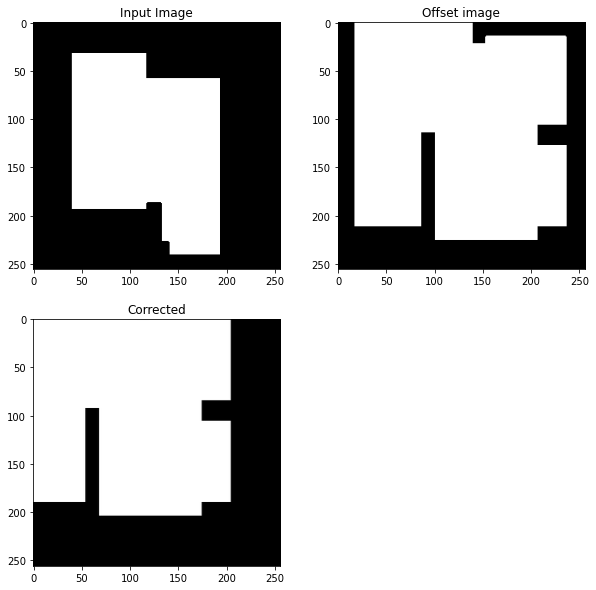

In [13]:
#Method 2: cross_correlation_shifts 

from image_registration import cross_correlation_shifts
xoff, yoff = cross_correlation_shifts(image, offset_image)


print("Pixels shifted by: ", xoff, yoff)


from scipy.ndimage import shift
corrected_image = shift(offset_image, shift=(xoff,yoff), mode='constant')

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(offset_image, cmap='gray')
ax2.title.set_text('Offset image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(corrected_image, cmap='gray')
ax3.title.set_text('Corrected')
plt.show()

Offset image was translated by: 18.75, -17.45
Pixels shifted by:  4.421864 -5.6980085


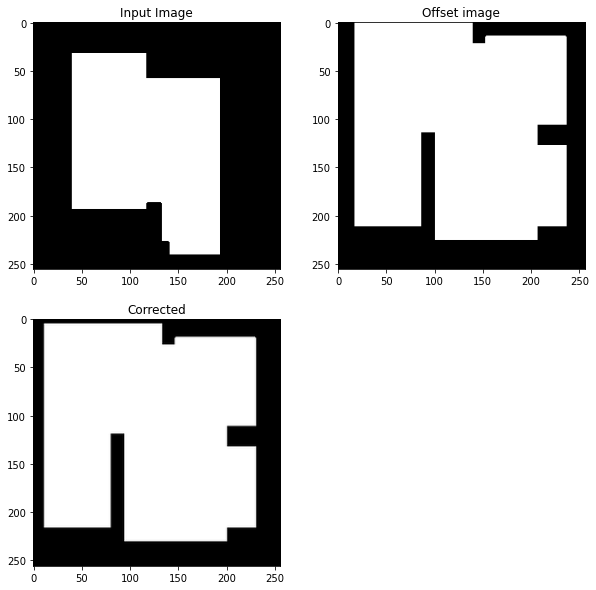

In [14]:
#Method 3: mean of all pixels
from skimage import registration
flow = registration.optical_flow_tvl1(image, offset_image)

# display dense optical flow
flow_x = flow[1, :, :]
flow_y = flow[0, :, :]


#Let us find the mean of all pixels in x and y and shift image by that amount
#ideally, you need to move each pixel by the amount from flow
import numpy as np
xoff = np.mean(flow_x)
yoff = np.mean(flow_y)


print("Offset image was translated by: 18.75, -17.45")
print("Pixels shifted by: ", xoff, yoff)


from scipy.ndimage import shift
corrected_image = shift(offset_image, shift=(xoff,yoff), mode='constant')

cv2.imwrite('corrected_image.png', corrected_image)

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(offset_image, cmap='gray')
ax2.title.set_text('Offset image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(corrected_image, cmap='gray')
ax3.title.set_text('Corrected')
plt.show()

In [ ]:
import numpy as np
import cv2

# Read input image
img1 = cv2.imread('/content/content/train_input/10008.png')
img = cv2.imread('/content/content/train_output/10008.png')
img2 = cv2.imread('./corrected_image.png')


grid_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Gel all pixels in the image - where BGR = (34, 33, 33), OpenCV colors order is BGR not RGB
# yellow rooms
gray = np.all(grid_rgb == (254, 223, 130), 2)
gray += np.all(grid_rgb == (254, 224, 128), 2)
gray += np.all(grid_rgb == (253, 223, 128), 2)

# Convert logical matrix to uint8
gray = gray.astype(np.uint8)*255

# Find contours
cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]  # Use index [-2] to be compatible to OpenCV 3 and 4

c = max(cnts, key=cv2.contourArea)

for c in cnts:
    x, y, w, h = cv2.boundingRect(c)

    # Draw green rectangle for testing
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), thickness = 2)
    cv2.rectangle(img2, (x, y), (x+w, y+h), (0, 255, 0), thickness = 2)
    cv2.rectangle(img1, (x, y), (x+w, y+h), (0, 255, 0), thickness = 2)

# Show result
cv2_imshow(gray)
cv2_imshow(img)
cv2_imshow(img2)
cv2_imshow(img1)

 
cv2.waitKey(0)
cv2.destroyAllWindows()

In [30]:
#function to align the thermal and visible image, it returns the homography matrix 
def alignImages(im1, im2,filename):
 
  # Convert images to grayscale
  im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
   
  # Detect ORB features and compute descriptors.
  orb = cv2.ORB_create(MAX_FEATURES)
  keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
   
  # Match features.
  matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matches = matcher.match(descriptors1, descriptors2, None)
   
  # Sort matches by score
  matches.sort(key=lambda x: x.distance, reverse=False)

  # experimenting
#   matches.sort(key=lambda y: y.distance, reverse=False)
 
  # Remove not so good matches
  numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:numGoodMatches]
 
  # Draw top matches
  imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
  cv2.imwrite(os.path.join('./registration/',filename), imMatches)
   
  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)
 
  for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt
   
  # Find homography
  h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
 
  # Use homography
  height, width, channels = im2.shape
#   print(im2.shape)
#   height, width = im2.shape
  im1Reg = cv2.warpPerspective(im1, h, (width, height))
   
  return im1Reg, h


In [31]:
import cv2
image1 = "/content/photos/1.png"
image2 = "/content/photos/1.png"

image = io.imread(image1)
offset_image = io.imread(image2)

image = cv2.imread(image1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
w, h = image.shape

offset_image = cv2.imread(image2)
offset_image = cv2.cvtColor(offset_image, cv2.COLOR_BGR2GRAY)
offset_image = cv2.resize(offset_image, (h,w)) 

# Resize both images to same shape
offset_image = resize_image(offset_image)
image = resize_image(image)
# Rotate offset_image
offset_image = rotate_image(offset_image)

# conver to complete black
offset_image = color_it_black(offset_image)
image = color_it_black(image)

# Save Both
file1 = "/content/original.png"
file2 = "/content/offset.png"
cv2.imwrite(file1, image)
cv2.imwrite(file2, offset_image)

(256, 256) 0 255
(256, 256) 0 255
(256, 256) 0 255
(256, 256) 0 255


True

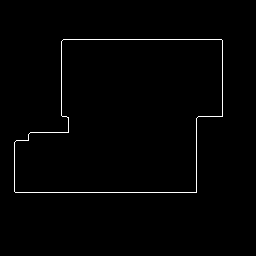

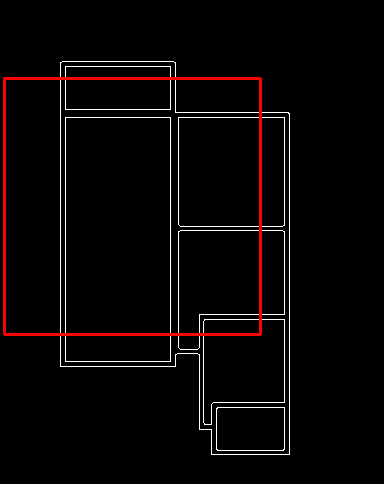

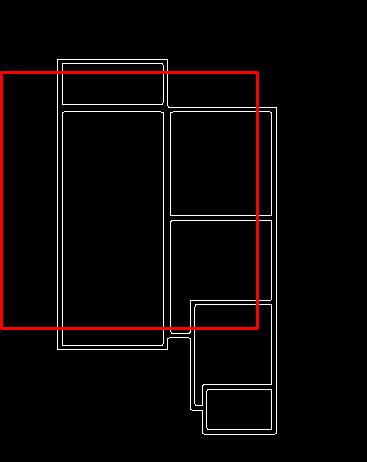

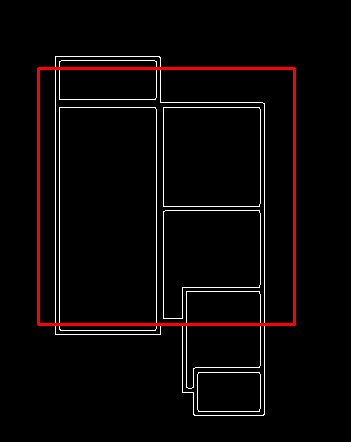

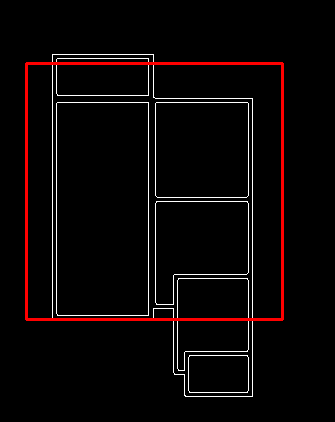

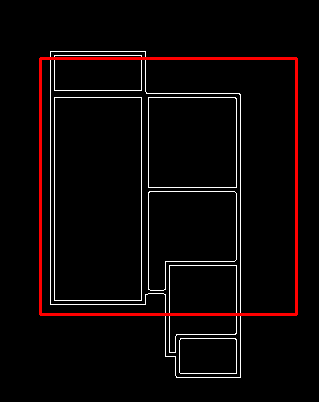

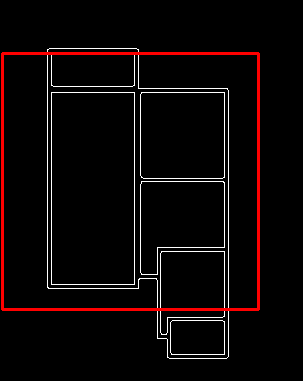

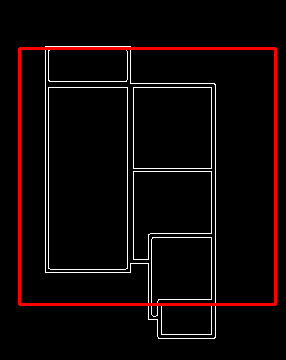

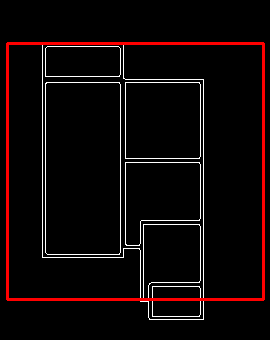

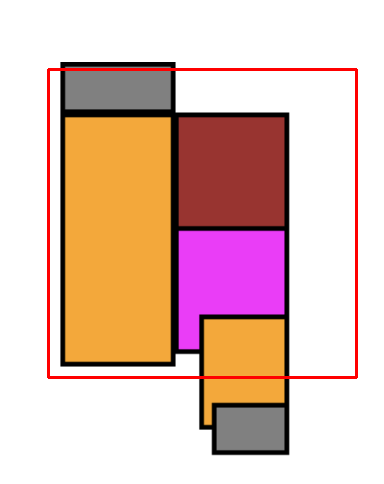

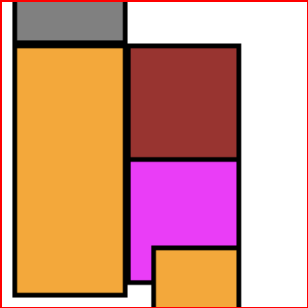

Reading reference image :  /content/offset.png
Reading image to align :  /content/photos/1.png
Estimated homography : 
 [[-8.86292443e-01 -3.92104419e-02  1.94388356e+02]
 [-8.70655573e-01 -3.81535910e-02  1.90805281e+02]
 [-4.56324641e-03 -1.99922819e-04  1.00000000e+00]]


In [33]:
# ORB
from __future__ import print_function
import numpy as np
import argparse
import imutils
import glob
import cv2
import os
import argparse


MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15



path_thermal = file2
# path_thermal = './test.png'
path_black = image1#file2
# path_thermal = './input.png'
# path_black = './output.png'

show = True

# put the thermal image in a folder named thermal and the visible image in a folder named visible with the same name
# load the image image, convert it to grayscale, and detect edges
template = cv2.imread(path_thermal)
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
template = cv2.Canny(template, 50, 200)
(tH, tW) = template.shape[:2]
cv2_imshow(template)

# loop over the images to find the template in

# load the image, convert it to grayscale, and initialize the
# bookkeeping variable to keep track of the matched region
image = cv2.imread(path_black)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
found = None

# loop over the scales of the image
for scale in np.linspace(0.2, 1.0, 20)[::-1]:
    # resize the image according to the scale, and keep track
    # of the ratio of the resizing
    resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
    r = gray.shape[1] / float(resized.shape[1])

    # if the resized image is smaller than the template, then break
    # from the loop
    if resized.shape[0] < tH or resized.shape[1] < tW:
        break

    # detect edges in the resized, grayscale image and apply template
    # matching to find the template in the image
    edged = cv2.Canny(resized, 50, 200)
    result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF)
    (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

    # check to see if the iteration should be visualized
    if show:
        # draw a bounding box around the detected region
        clone = np.dstack([edged, edged, edged])
        cv2.rectangle(clone, (maxLoc[0], maxLoc[1]),
            (maxLoc[0] + tW, maxLoc[1] + tH), (0, 0, 255), 2)
        cv2_imshow(clone)
        cv2.waitKey(0)

    # if we have found a new maximum correlation value, then update
    # the bookkeeping variable
    if found is None or maxVal > found[0]:
        found = (maxVal, maxLoc, r)

# unpack the bookkeeping variable and compute the (x, y) coordinates
# of the bounding box based on the resized ratio
(_, maxLoc, r) = found
(startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
(endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))

# draw a bounding box around the detected result and display the image
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
crop_img = image[startY:endY, startX:endX]
cv2_imshow(image)
cv2_imshow(crop_img)

name = path_thermal#"thermal/"+args["image"]
thermal_image = cv2.imread(name, cv2.IMREAD_COLOR)

#cropping out the matched part of the thermal image
crop_img = cv2.resize(crop_img, (thermal_image.shape[1], thermal_image.shape[0]))

#cropped image will be saved in a folder named output
cv2.imwrite("test.png",crop_img)

#both images are concatenated and saved in a folder named results
final = np.concatenate((crop_img, thermal_image), axis = 1)
cv2.imwrite("result.png",final)

cv2.waitKey(0)
# Registration
# Read reference image
refFilename = path_thermal
print("Reading reference image : ", refFilename)
imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

# Read image to be aligned
imFilename = path_black
print("Reading image to align : ", imFilename);  
im = cv2.imread(imFilename, cv2.IMREAD_COLOR)
file_name="10008.png"
imReg, h = alignImages(im,imReference,file_name)
print("Estimated homography : \n",  h)

In [ ]:
import numpy as np
import cv2

# Read input image
# img1 = cv2.imread('/content/content/train_output/10008.png')
# img = cv2.imread('/content/test.png')
# img2 = cv2.imread('/content/content/train_input/10008.png')
img1 = cv2.imread('./corrected_image.png')
img = cv2.imread('./test.png')
img2 = cv2.imread('/content/content/train_input/10008.png')

grid_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Gel all pixels in the image - where BGR = (34, 33, 33), OpenCV colors order is BGR not RGB
# yellow rooms
gray = np.all(grid_rgb == (254, 223, 130), 2)
gray += np.all(grid_rgb == (254, 224, 128), 2)
gray += np.all(grid_rgb == (253, 223, 128), 2)


# Convert logical matrix to uint8
gray = gray.astype(np.uint8)*255

# Find contours
cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]  # Use index [-2] to be compatible to OpenCV 3 and 4

c = max(cnts, key=cv2.contourArea)

for c in cnts:
    x, y, w, h = cv2.boundingRect(c)

    # Draw green rectangle for testing
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), thickness = 2)
    cv2.rectangle(img2, (x, y), (x+w, y+h), (0, 255, 0), thickness = 2)
    cv2.rectangle(img1, (x, y), (x+w, y+h), (0, 255, 0), thickness = 2)

# Show result
cv2_imshow(gray)
cv2_imshow(img)
cv2_imshow(img2)
cv2_imshow(img1)

 
cv2.waitKey(0)
cv2.destroyAllWindows()

Pixels shifted by:  12.66 20.85


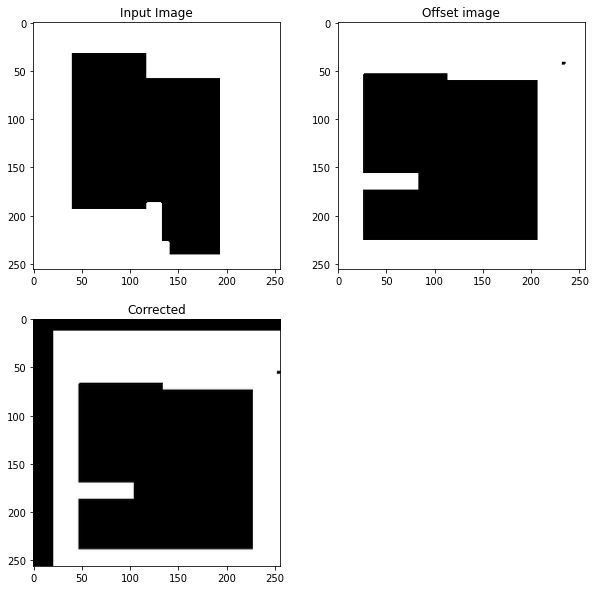

In [7]:
from image_registration import cross_correlation_shifts
from skimage.feature import register_translation

shifted, error, diffphase = register_translation(image, offset_image, 100)
xoff = -shifted[1]
yoff = -shifted[0]


print("Pixels shifted by: ", xoff, yoff)


from scipy.ndimage import shift
corrected_image = shift(offset_image, shift=(xoff,yoff), mode='constant')

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(offset_image, cmap='gray')
ax2.title.set_text('Offset image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(corrected_image, cmap='gray')
ax3.title.set_text('Corrected')
plt.show()

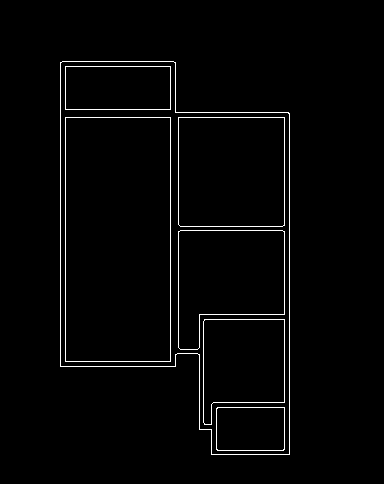

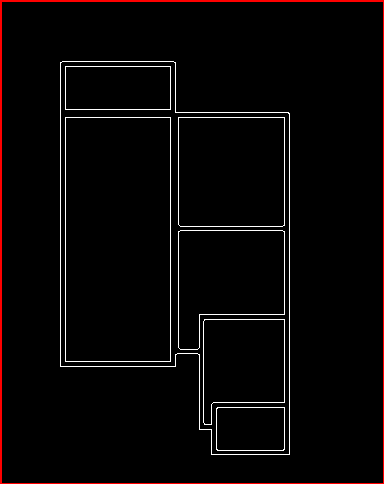

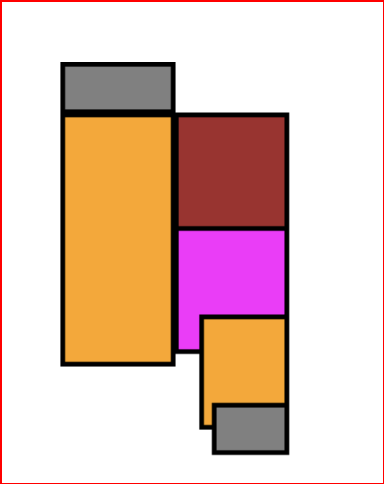

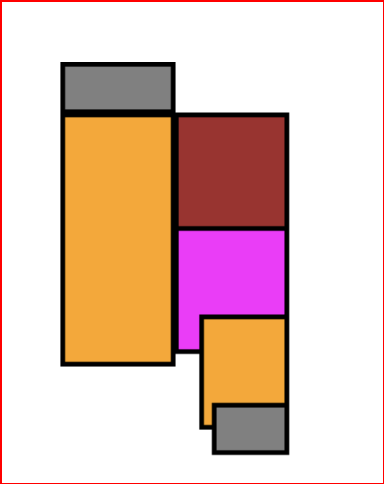

Reading reference image :  /content/photos/1.png
Reading image to align :  /content/photos/1.png


NameError: ignored

In [15]:
# Only ORB
from __future__ import print_function
import numpy as np
import argparse
import imutils
import glob
import cv2
import os
import argparse


MAX_FEATURES = 1000#500
GOOD_MATCH_PERCENT = 0.15



path_thermal = image1
# path_thermal = './test.png'
path_black = image2
# path_thermal = './input.png'
# path_black = './output.png'

show = True

# put the thermal image in a folder named thermal and the visible image in a folder named visible with the same name
# load the image image, convert it to grayscale, and detect edges
template = cv2.imread(path_thermal)
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
template = cv2.Canny(template, 50, 200)
(tH, tW) = template.shape[:2]
cv2_imshow(template)

# loop over the images to find the template in

# load the image, convert it to grayscale, and initialize the
# bookkeeping variable to keep track of the matched region
image = cv2.imread(path_black)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
found = None

# loop over the scales of the image
for scale in np.linspace(0.2, 1.0, 20)[::-1]:
    # resize the image according to the scale, and keep track
    # of the ratio of the resizing
    resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
    r = gray.shape[1] / float(resized.shape[1])

    # if the resized image is smaller than the template, then break
    # from the loop
    if resized.shape[0] < tH or resized.shape[1] < tW:
        break

    # detect edges in the resized, grayscale image and apply template
    # matching to find the template in the image
    edged = cv2.Canny(resized, 50, 200)
    result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF)
    (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

    # check to see if the iteration should be visualized
    if show:
        # draw a bounding box around the detected region
        clone = np.dstack([edged, edged, edged])
        cv2.rectangle(clone, (maxLoc[0], maxLoc[1]),
            (maxLoc[0] + tW, maxLoc[1] + tH), (0, 0, 255), 2)
        cv2_imshow(clone)
        cv2.waitKey(0)

    # if we have found a new maximum correlation value, then update
    # the bookkeeping variable
    if found is None or maxVal > found[0]:
        found = (maxVal, maxLoc, r)

# unpack the bookkeeping variable and compute the (x, y) coordinates
# of the bounding box based on the resized ratio
(_, maxLoc, r) = found
(startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
(endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))

# draw a bounding box around the detected result and display the image
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
crop_img = image[startY:endY, startX:endX]
cv2_imshow(image)
cv2_imshow(crop_img)

name = path_thermal#"thermal/"+args["image"]
thermal_image = cv2.imread(name, cv2.IMREAD_COLOR)

#cropping out the matched part of the thermal image
crop_img = cv2.resize(crop_img, (thermal_image.shape[1], thermal_image.shape[0]))

#cropped image will be saved in a folder named output
cv2.imwrite("test.png",crop_img)

#both images are concatenated and saved in a folder named results
final = np.concatenate((crop_img, thermal_image), axis = 1)
cv2.imwrite("result.png",final)

cv2.waitKey(0)
# Registration
# Read reference image
refFilename = path_thermal
print("Reading reference image : ", refFilename)
imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

# Read image to be aligned
imFilename = path_black
print("Reading image to align : ", imFilename);  
im = cv2.imread(imFilename, cv2.IMREAD_COLOR)
file_name="10008.png"
imReg, h = alignImages(im,imReference,file_name)
print("Estimated homography : \n",  h)

In [ ]:
import numpy as np
import cv2

# Read input image
img1 = cv2.imread('/content/content/train_output/10008.png')
img = cv2.imread('/content/test.png')
img2 = cv2.imread('/content/content/train_input/10008.png')
# img1 = cv2.imread('./output.png')
# img = cv2.imread('/content/test.png')
# img2 = cv2.imread('./input.png)

grid_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Gel all pixels in the image - where BGR = (34, 33, 33), OpenCV colors order is BGR not RGB
# yellow rooms
gray = np.all(grid_rgb == (254, 223, 130), 2)
gray += np.all(grid_rgb == (254, 224, 128), 2)
gray += np.all(grid_rgb == (253, 223, 128), 2)
# clay
# gray += np.all(grid_rgb == (193, 254, 255), 2)
# gray += np.all(grid_rgb == (201, 233, 240), 2)  # gray is a logical matrix with True where BGR = (34, 33, 33).

# gray += np.all(grid_rgb == (254, 224, 226), 2)
# gray += np.all(grid_rgb == (247, 70, 70), 2)
# gray += np.all(grid_rgb == (225, 255, 193), 2)
# gray += np.all(grid_rgb == (34, 80, 230), 2)
# gray += np.all(grid_rgb == (114, 59, 12), 2)
# gray += np.all(grid_rgb == (247, 158, 98), 2)
# gray += np.all(grid_rgb == (192, 192, 225), 2)
# gray += np.all(grid_rgb == (193, 254, 255), 2)
# gray += np.all(grid_rgb == (193, 192, 224), 2)
# gray += np.all(grid_rgb == (121, 63, 13), 2)
# gray += np.all(grid_rgb == (248, 158, 98), 2)
# gray += np.all(grid_rgb == (226, 236, 189), 2)
# gray += np.all(grid_rgb == (226, 236, 189), 2)
# gray += np.all(grid_rgb == (238, 71, 72), 2)
# gray += np.all(grid_rgb == (254, 224, 128), 2)
# gray += np.all(grid_rgb == (80, 94, 107), 2)
# gray += np.all(grid_rgb == (255, 160, 90), 2)


# Convert logical matrix to uint8
gray = gray.astype(np.uint8)*255

# Find contours
cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]  # Use index [-2] to be compatible to OpenCV 3 and 4

c = max(cnts, key=cv2.contourArea)

for c in cnts:
    x, y, w, h = cv2.boundingRect(c)

    # Draw green rectangle for testing
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), thickness = 2)
    cv2.rectangle(img2, (x, y), (x+w, y+h), (0, 255, 0), thickness = 2)
    cv2.rectangle(img1, (x, y), (x+w, y+h), (0, 255, 0), thickness = 2)

# Show result
cv2_imshow(gray)
cv2_imshow(img)
cv2_imshow(img2)
cv2_imshow(img1)

 
cv2.waitKey(0)
cv2.destroyAllWindows()

## check if image are same

In [ ]:
# check 
import cv2
import numpy as np
original = cv2.imread(file1)
duplicate = cv2.imread(file1)

if original.shape == duplicate.shape:
    print("The images have same size and channels")
difference = cv2.subtract(original, duplicate)
print(difference.sum()/original.sum())
b, g, r = cv2.split(difference)
if cv2.countNonZero(b) == 0 and cv2.countNonZero(g) == 0 and cv2.countNonZero(r) == 0:
    print("The images are completely Equal")    

cv2_imshow(original)
cv2_imshow(duplicate)

cv2.waitKey(0)
cv2.destroyAllWindows()

# Image Filtering final

In [ ]:
!pip install image_registration

In [129]:
import cv2
import numpy as np
# import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
import PIL
from PIL import Image
from image_registration import chi2_shift
from scipy.ndimage import shift

def resize_image(image):
    return cv2.resize(image, (256, 256), interpolation = cv2.INTER_CUBIC)

def rotate_image(image):
    return cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)

def color_it_black(image):
    np_image = np.array(image)
    for i in range(np_image.shape[0]):
        for j in range(np_image.shape[1]):
            # np_image[i,j] = 0 if np_image[i,j] < 200 else 255
            np_image[i,j] = 255 if np_image[i,j] < 200 else 0
    return np_image

def masking(image):
    np_image = np.array(image)
    for i in range(np_image.shape[0]):
        for j in range(np_image.shape[1]):
            np_image[i,j] = 0 if np_image[i,j] == 255 else 1
    return np_image

def white_to_black(image):
    np_image = np.array(image)
    for i in range(np_image.shape[0]):
        for j in range(np_image.shape[1]):
            np_image[i,j] = 255 if np_image[i,j] == 0 else 0
    return np_image


/usr/local/lib/python3.7/dist-packages/image_registration/fft_tools/convolve_nd.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/usr/local/lib/python3.7/dist-packages/image_registration/fft_tools/convolve_nd.py:270: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = kernel
/usr/local/lib/python3.7/dist-packages/image_registration/fft_tools/convolve_nd.py:325: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[se

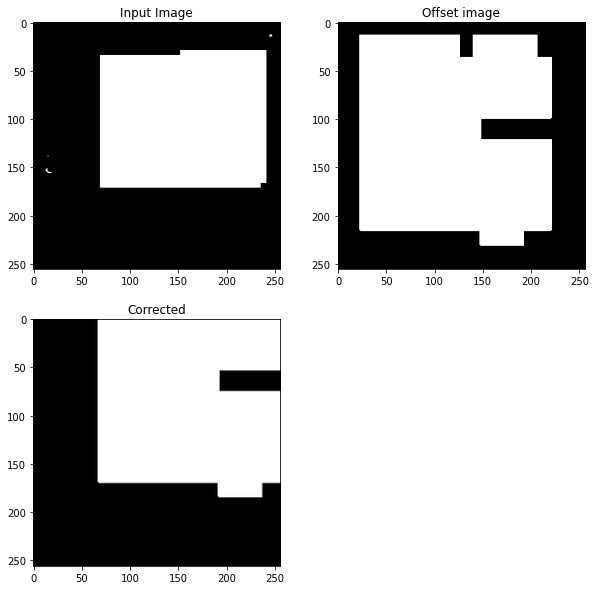

In [166]:
#Method 1: chi squared shift

generated_path = "/content/photos/4.png"
input_imgshape = "/content/photos/5.png"



generated_image = cv2.imread(generated_path)
# Rotate offset_image
generated_image = rotate_image(generated_image)
image = cv2.cvtColor(generated_image, cv2.COLOR_BGR2GRAY)
w, h = image.shape

offset_image = cv2.imread(input_imgshape)
offset_image = cv2.cvtColor(offset_image, cv2.COLOR_BGR2GRAY)
offset_image = cv2.resize(offset_image, (h,w)) 

# Resize both images to same shape
offset_image = resize_image(offset_image)
image = resize_image(image)


# conver to complete black
offset_image = color_it_black(offset_image)
image = color_it_black(image)
# print(image.shape, offset_image.shape)

#Method 1: chi squared shift
#Find the offsets between image 1 and image 2 using the DFT upsampling method
noise=0.1
xoff, yoff, exoff, eyoff = chi2_shift(image, offset_image, noise, 
                                      return_error=True, upsample_factor='auto')

# print("Pixels shifted by: ", xoff, yoff)

corrected_image = shift(offset_image, shift=(xoff,yoff), mode='constant')

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image, cmap='gray')
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(offset_image, cmap='gray')
ax2.title.set_text('Offset image')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(corrected_image, cmap='gray')
ax3.title.set_text('Corrected')
plt.show()

The images have same size and channels
77.20455475577168 71.30519106639595


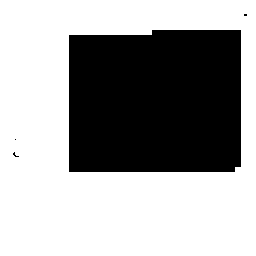

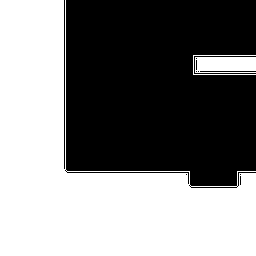

In [167]:
# check 
import cv2
import numpy as np
original = white_to_black(image) #cv2.imread(file1)
duplicate = white_to_black(corrected_image)

if original.shape == duplicate.shape:
    print("The images have same size and channels")
difference = cv2.subtract(original, duplicate)
# Inverse difference
difference_2 = cv2.subtract(original, duplicate)
# Maching Score
score1 = (1 - difference.sum()/original.sum())*100
score2 = (1 - difference_2.sum()/duplicate.sum())*100
print(score1,score2)

dif = cv2.split(difference)[0]
if cv2.countNonZero(dif) == 0:
    print("The images are completely Equal")    

cv2_imshow(original)
cv2_imshow(duplicate)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [168]:
np.array(cv2.split(difference)[0]).shape

(256, 256)

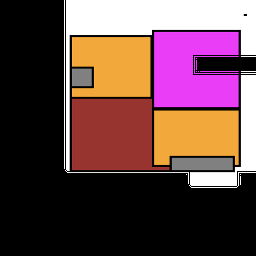

In [169]:
# Output
# generated_image = cv2.cvtColor(generated_image, cv2.COLOR_BGR2RGB)
generated_image = resize_image(generated_image)

duplicate = masking(duplicate)
for i in range(3):
    generated_image[:,:,i] = duplicate * generated_image[:,:,i]
cv2_imshow(generated_image)



In [96]:
generated_image.max(), duplicate.max()

(255, 1)

In [135]:
from scipy.ndimage import shift

def fit_boundary(generated_image, boundary):
    final_image = None
    max_score = 70
    for iter in range(4):
        # Rotate offset_image
        generated_image = rotate_image(generated_image)
        image = cv2.cvtColor(generated_image, cv2.COLOR_BGR2GRAY)
        w, h = image.shape

        # offset_image = cv2.imread(input_imgshape)
        offset_image = boundary
        offset_image = cv2.cvtColor(offset_image, cv2.COLOR_BGR2GRAY)
        offset_image = cv2.resize(offset_image, (h,w)) 

        # Resize both images to same shape
        offset_image = resize_image(offset_image)
        image = resize_image(image)


        # conver to complete black
        offset_image = color_it_black(offset_image)
        image = color_it_black(image)
        # print(image.shape, offset_image.shape)

        #Method 1: chi squared shift
        #Find the offsets between image 1 and image 2 using the DFT upsampling method
        noise=0.1
        xoff, yoff, exoff, eyoff = chi2_shift(image, offset_image, noise, 
                                            return_error=True, upsample_factor='auto')

        # print("Pixels shifted by: ", xoff, yoff)

        corrected_image = shift(offset_image, shift=(xoff,yoff), mode='constant')


        original = white_to_black(image) #cv2.imread(file1)
        duplicate = white_to_black(corrected_image)
        difference = cv2.subtract(original, duplicate)
        # Inverse difference
        difference_2 = cv2.subtract(original, duplicate)
        # Maching Score
        score = ((1 - difference.sum()/original.sum()) + (1 - difference_2.sum()/duplicate.sum()))*100/2
        if score > max_score:
            max_score = score
            final_image = generated_image

        dif = cv2.split(difference)[0]
        if cv2.countNonZero(dif) == 0:
            print("The images are completely Equal")    

        cv2_imshow(original)
        cv2_imshow(duplicate)

        cv2.waitKey(0)
        cv2.destroyAllWindows()

        final_image = resize_image(final_image)
        duplicate = masking(duplicate)
        for i in range(3):
            final_image[:,:,i] = duplicate * final_image[:,:,i]
        cv2_imshow(final_image)

        return max_score > 70, final_image



In [ ]:
generated_path = "/content/photos/3.png"
input_imgshape = "/content/photos/3.png"

generated_image = cv2.imread(generated_path)
boundary = cv2.imread(input_imgshape)

check, final_image = fit_boundary(generated_image, boundary)